In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K
import logging


In [3]:
base_dir = '/content/drive/MyDrive/Colab Notebooks'
data_dir = os.path.join(base_dir, 'EEG_SHCEEEZ-DL', 'out')
a_dataset = pathlib.Path(os.path.join(data_dir, 'F'))

In [4]:
image_count = len(list(a_dataset.glob('*/*.png')))
print('number of total images:', image_count, '\n\n')

number of total images: 516 




In [5]:
models_path = os.path.join(base_dir, 'EEG_SCHEEEZ-DL', 'models')


In [6]:

height = 224
width = 224

def image_read(image_dir):
  src = cv2.imread(image_dir)
  src_rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  image = cv2.resize(src_rgb, (width, height))
  image = image.astype('float32') / 255.
  return image



def images_from_directory(a_dataset, cat):
  image_list = []
  images_path = os.path.join(a_dataset, cat)
  images_names = [os.path.join(images_path, name) for name in os.listdir(images_path)]
  for image_dir in images_names:
    image = image_read(image_dir)
    image_list.append(image)
  return image_list


norm_list = images_from_directory(a_dataset, 'norm')
sch_list  = images_from_directory(a_dataset, 'sch')

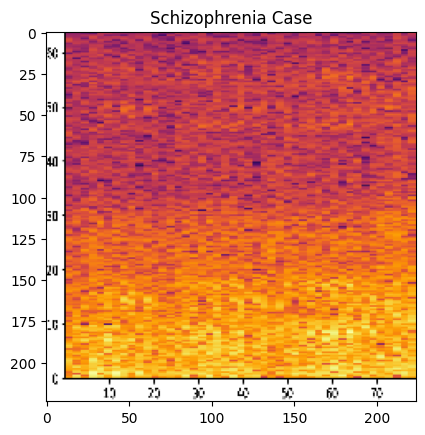

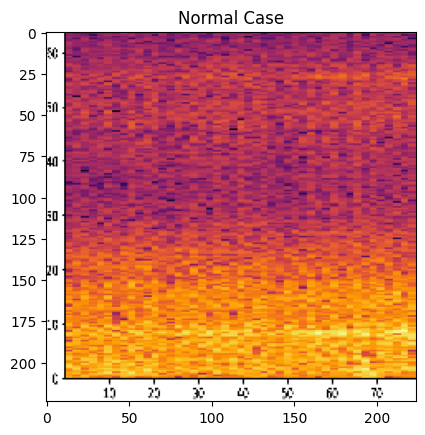

In [7]:

import matplotlib.pyplot as plt

i = 2
plt.title("Schizophrenia Case")
plt.imshow(sch_list[i])
plt.show()
plt.title("Normal Case")
plt.imshow(norm_list[i])
plt.show()


In [8]:

print("size of normal image dataset:", len(norm_list))
print("size of schizophrenic dataset:", len(sch_list))
print(norm_list[0].shape)


size of normal image dataset: 216
size of schizophrenic dataset: 300
(224, 224, 3)


In [9]:

X_norm = np.array(norm_list)
X_sch = np.array(sch_list)


In [10]:
X_norm.shape, X_sch.shape


((216, 224, 224, 3), (300, 224, 224, 3))

In [11]:
def train_validation_split(X, ratio=0.2):
  length = int(ratio * X.shape[0])
  return X[length:], X[:length]


X_norm_train, X_norm_valid = train_validation_split(X_norm)
X_sch_train, X_sch_valid = train_validation_split(X_sch)

X_norm_train.shape, X_norm_valid.shape, X_sch_train.shape, X_sch_valid.shape

((173, 224, 224, 3), (43, 224, 224, 3), (240, 224, 224, 3), (60, 224, 224, 3))

In [12]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows), dpi=190)
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [13]:

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



In [15]:
tf.random.set_seed(42)
np.random.seed(42)

latent_dim = 512


def encoder(inputs):
  # (224, 224, 3)

  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
  # (112, 112, 32)

  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
  # (7, 7, 512)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(1024, activation="relu")(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  v_encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
  v_encoder.summary()
  return v_encoder, z_log_var, z_mean


def decoder():
  latent_inputs = keras.Input(shape=(latent_dim,))

  x = layers.Dense(1024, activation="relu")(latent_inputs)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(7*7*512, activation="relu")(x)
  x = layers.Reshape((7, 7, 512))(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  # (112, 112, 32)

  decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid",  strides=2, padding="same")(x)
  v_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  v_decoder.summary()
  return v_decoder


In [16]:
inputs = keras.layers.Input(shape=(224, 224, 3))
norm_encoder, norm_codings_log_var, norm_codings_mean = encoder(inputs)
norm_decoder = decoder()
_, _, norm_codings = norm_encoder(inputs)
norm_reconstructions = norm_decoder(norm_codings)
norm_vae = keras.models.Model(inputs=[inputs], outputs=[norm_reconstructions])

latent_loss = -0.5 * K.sum(1 + norm_codings_log_var - K.exp(norm_codings_log_var) - K.square(norm_codings_mean), axis=-1)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 28, 28, 128)          73856     ['conv2d_1[0][0]']            
                                                                                            

In [17]:
norm_vae.add_loss(K.mean(latent_loss) / (224*224*3))
rms_prop = keras.optimizers.Adam(learning_rate = 0.00008)
norm_vae.compile(loss="binary_crossentropy", optimizer= rms_prop, metrics=[rounded_accuracy])
history = norm_vae.fit(X_norm_train, X_norm_train, epochs=50, batch_size=32, validation_data=(X_norm_valid, X_norm_valid))

Epoch 1/50
6/6 [==============================] - 39s 6s/step - loss: 0.6930 - rounded_accuracy: 0.5963 - val_loss: 0.6929 - val_rounded_accuracy: 0.7052
Epoch 2/50
6/6 [==============================] - 33s 6s/step - loss: 0.6928 - rounded_accuracy: 0.7341 - val_loss: 0.6926 - val_rounded_accuracy: 0.7638
Epoch 3/50
6/6 [==============================] - 31s 5s/step - loss: 0.6925 - rounded_accuracy: 0.7718 - val_loss: 0.6922 - val_rounded_accuracy: 0.7763
Epoch 4/50
6/6 [==============================] - 32s 5s/step - loss: 0.6920 - rounded_accuracy: 0.7769 - val_loss: 0.6915 - val_rounded_accuracy: 0.7737
Epoch 5/50
6/6 [==============================] - 34s 6s/step - loss: 0.6910 - rounded_accuracy: 0.7720 - val_loss: 0.6898 - val_rounded_accuracy: 0.7659
Epoch 6/50
6/6 [==============================] - 33s 6s/step - loss: 0.6882 - rounded_accuracy: 0.7624 - val_loss: 0.6836 - val_rounded_accuracy: 0.7553
Epoch 7/50
6/6 [==============================] - 34s 6s/step - loss: 0.6776

In [19]:
final_accuracy = history.history['rounded_accuracy'][-1]

In [20]:
print(f"FFT VAE accuracy: {final_accuracy * 100:.2f} %")

FFT VAE accuracy: 95.49 %
